In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications import ResNet50, xception, MobileNet, Xception, VGG16
from tensorflow.keras.applications.resnet50  import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings(action='ignore')

### # dataset load

In [3]:
# import pickle5 as pickle

# with open('E:/olive_young/CNN_transfer_learning/x_train.pickle',"rb") as fr:
#     x_train = pickle.load(fr, encoding='bytes')
# with open('E:/olive_young/CNN_transfer_learning/x_trn.pickle',"rb") as fr:
#     x_trn = pickle.load(fr, encoding='bytes')
# with open('E:/olive_young/CNN_transfer_learning/x_test.pickle',"rb") as fr:
#     x_test = pickle.load(fr, encoding='bytes')
# with open('E:/olive_young/CNN_transfer_learning/x_ts.pickle',"rb") as fr:
#     x_ts  = pickle.load(fr, encoding='bytes')
# with open('E:/olive_young/CNN_transfer_learning/y_train.pickle',"rb") as fr:
#     y_train  = pickle.load(fr, encoding='bytes')
# with open('E:/olive_young/CNN_transfer_learning/y_test.pickle',"rb") as fr:
#     y_test  = pickle.load(fr, encoding='bytes')
    
x_train =  pd.read_pickle('E:/olive_young/CNN_transfer_learning/x_train.pickle')
x_trn =  pd.read_pickle('E:/olive_young/CNN_transfer_learning/x_trn.pickle')
x_test =  pd.read_pickle('E:/olive_young/CNN_transfer_learning/x_test.pickle')
x_ts =  pd.read_pickle('E:/olive_young/CNN_transfer_learning/x_ts.pickle')
y_train =  pd.read_pickle('E:/olive_young/CNN_transfer_learning/y_train.pickle')
y_test =  pd.read_pickle('E:/olive_young/CNN_transfer_learning/y_test.pickle')
    
print(x_train.shape, x_trn.shape)
print(x_test.shape, x_ts.shape)
print(y_train.shape, y_test.shape)

(14400, 200, 150, 3) (14400, 200, 150, 3)
(3600, 200, 150, 3) (3600, 200, 150, 3)
(14400,) (3600,)


## # CNN Transfer learning

* ResNet
* MobileNet
* VGGNet
* Xception

In [8]:
def build_transfer_model(pre_trained_model):
    # Some weights in later layers are unfreezed
    for layer in pre_trained_model.layers[:-5]:
        layer.trainable=False
    model = pre_trained_model.output
    model = AveragePooling2D(pool_size=(3,3))(model)
    model = Flatten(name="flatten")(model)
    model = Dense(128,activation='relu')(model)
    model = Dropout(0.5)(model)
    model = Dense(30, activation='softmax')(model)
    model = Model(inputs=pre_trained_model.input, outputs=model)
    return model

def model_compile(model, learning_rate):
    sgd = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,
                  loss=['sparse_categorical_crossentropy'], 
                metrics=['accuracy'])
    return model

In [9]:
input_shape = (x_trn.shape[1], x_trn.shape[2], 3)

pre_resNet = ResNet50(input_shape=input_shape,
                  include_top=False,
                  weights="imagenet")
pre_mobileNet = MobileNet(input_shape=input_shape,
                  include_top=False,
                  weights="imagenet")
pre_vgg16= VGG16(input_shape=input_shape,
                  include_top=False,
                  weights="imagenet")
pre_xception = Xception(input_shape=input_shape,
                  include_top=False,
                  weights="imagenet")

In [11]:
xception = pre_xception.output
xception = AveragePooling2D(pool_size=(3,3))(xception)
xception = Flatten(name="flatten")(xception)
xception = Dense(256,activation='relu')(xception)
xception = Dense(128,activation='relu')(xception)
xception = Dropout(0.5)(xception)
xception = Dense(30, activation='softmax')(xception)
xception = Model(inputs=pre_xception.input, outputs=xception)

In [10]:
resNet = build_transfer_model(pre_resNet)
mobileNet = build_transfer_model(pre_mobileNet)
vgg16 = build_transfer_model(pre_vgg16)

In [17]:
resNet = model_compile(resNet, 0.001)
mobileNet = model_compile(mobileNet, 0.001)
vgg16 = model_compile(vgg16, 0.001)
xception = model_compile(xception, 0.001)

In [4]:
resNet_path = 'E:/olive_young/CNN_transfer_learning/models/resNet_best_model.h5'
mobileNet_path = 'E:/olive_young/CNN_transfer_learning/models/mobileNet_best_model.h5'
vgg16_path = 'E:/olive_young/CNN_transfer_learning/models/vgg16_best_model.h5'
xception_path = 'E:/olive_young/CNN_transfer_learning/models/xception_best_model.h5'

In [19]:
cb_checkpoint_resNet = ModelCheckpoint(filepath=resNet_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)
cb_checkpoint_mobileNet = ModelCheckpoint(filepath=mobileNet_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)
cb_checkpoint_vgg16 = ModelCheckpoint(filepath=vgg16_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)
cb_checkpoint_xception = ModelCheckpoint(filepath=xception_path, monitor='val_accuracy',
                                verbose=1, save_best_only=True)

### # ResNet 

In [37]:
resNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 75, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 75, 64)  256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [20]:
resNet_history = resNet.fit(x_trn, y_train, 
                    validation_split=0.2, shuffle=True,
                    epochs=150, batch_size=32, callbacks=[cb_checkpoint_resNet])

Epoch 1/150
360/360 [==============================] - 75s 163ms/step - loss: 3.4031 - accuracy: 0.0359 - val_loss: 3.3948 - val_accuracy: 0.0385

Epoch 00001: val_accuracy improved from -inf to 0.03854, saving model to D:/dasol\resNet_best_model.h5
Epoch 2/150
360/360 [==============================] - 45s 124ms/step - loss: 3.3844 - accuracy: 0.0431 - val_loss: 3.3697 - val_accuracy: 0.0573

Epoch 00002: val_accuracy improved from 0.03854 to 0.05729, saving model to D:/dasol\resNet_best_model.h5
Epoch 3/150
360/360 [==============================] - 45s 124ms/step - loss: 3.3584 - accuracy: 0.0543 - val_loss: 3.3492 - val_accuracy: 0.0660

Epoch 00003: val_accuracy improved from 0.05729 to 0.06597, saving model to D:/dasol\resNet_best_model.h5
Epoch 4/150
360/360 [==============================] - 45s 124ms/step - loss: 3.3193 - accuracy: 0.0566 - val_loss: 3.2784 - val_accuracy: 0.0892

Epoch 00004: val_accuracy improved from 0.06597 to 0.08924, saving model to D:/dasol\resNet_best_

360/360 [==============================] - 45s 125ms/step - loss: 1.6939 - accuracy: 0.5006 - val_loss: 2.0674 - val_accuracy: 0.4076

Epoch 00075: val_accuracy did not improve from 0.49410
Epoch 76/150
360/360 [==============================] - 45s 125ms/step - loss: 1.6704 - accuracy: 0.5054 - val_loss: 1.8334 - val_accuracy: 0.4688

Epoch 00076: val_accuracy did not improve from 0.49410
Epoch 77/150
360/360 [==============================] - 45s 125ms/step - loss: 1.6772 - accuracy: 0.5073 - val_loss: 1.8620 - val_accuracy: 0.4573

Epoch 00077: val_accuracy did not improve from 0.49410
Epoch 78/150
360/360 [==============================] - 45s 125ms/step - loss: 1.6719 - accuracy: 0.5048 - val_loss: 1.8941 - val_accuracy: 0.4694

Epoch 00078: val_accuracy did not improve from 0.49410
Epoch 79/150
360/360 [==============================] - 45s 125ms/step - loss: 1.6505 - accuracy: 0.5116 - val_loss: 1.8490 - val_accuracy: 0.4611

Epoch 00079: val_accuracy did not improve from 0.4941

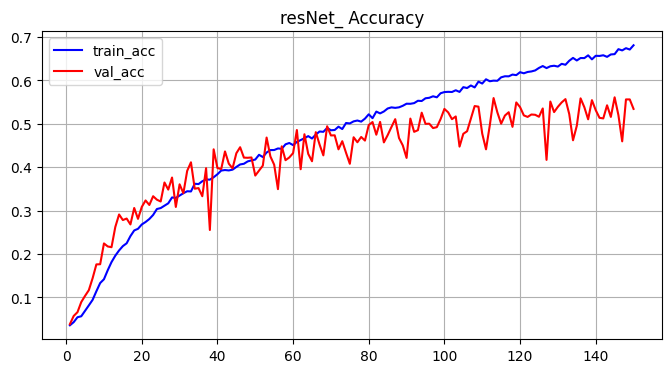

In [21]:
resNet_acc = resNet_history.history['accuracy']
resNet_val_acc = resNet_history.history['val_accuracy']

epochs = range(1, len(resNet_acc)+1)
plt.figure(figsize=(8, 4))
plt.title('resNet_ Accuracy')
plt.plot(epochs, resNet_acc, 'b', label='train_acc')
plt.plot(epochs, resNet_val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.show()

In [5]:
best_resNet = load_model(resNet_path)
resNet_test_res = best_resNet.evaluate(x_ts, y_test)
resNet_test_res

113/113 [==============================] - 186s 2s/step - loss: 1.5313 - accuracy: 0.5639


[1.531251072883606, 0.5638889074325562]

In [9]:
import time
start_time = time.time()
pred = best_resNet.predict(x_ts)
resNet_pred_time = time.time()-start_time
print("time : {}".format(resNet_pred_time))
print("pred shape:", pred.shape)

113/113 [==============================] - 144s 1s/step
time : 144.45266723632812
pred shape: (3600, 30)


In [13]:
# test image 1장 예측 시간
temp = x_ts[1].reshape(1, 200, 150, 3)
start_time = time.time()
p = best_resNet.predict(temp)
print("time : {}".format(time.time()-start_time))

time : 0.974989652633667


### # MobileNet 

In [38]:
mobileNet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 75, 32)       864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 100, 75, 32)       128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 100, 75, 32)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 100, 75, 32)       288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 100, 75, 32)       128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 100, 75, 32)       0   

In [25]:
mobileNet_history = mobileNet.fit(x_trn, y_train, 
                    validation_split=0.2, shuffle=True,
                    epochs=150, batch_size=32, callbacks=[cb_checkpoint_mobileNet])

Epoch 1/150
360/360 [==============================] - 36s 77ms/step - loss: 1.9030 - accuracy: 0.4756 - val_loss: 0.4606 - val_accuracy: 0.8997

Epoch 00001: val_accuracy improved from -inf to 0.89965, saving model to D:/dasol\mobileNet_best_model.h5
Epoch 2/150
360/360 [==============================] - 16s 44ms/step - loss: 0.6329 - accuracy: 0.8157 - val_loss: 0.2403 - val_accuracy: 0.9389

Epoch 00002: val_accuracy improved from 0.89965 to 0.93889, saving model to D:/dasol\mobileNet_best_model.h5
Epoch 3/150
360/360 [==============================] - 16s 44ms/step - loss: 0.3809 - accuracy: 0.8881 - val_loss: 0.1773 - val_accuracy: 0.9531

Epoch 00003: val_accuracy improved from 0.93889 to 0.95312, saving model to D:/dasol\mobileNet_best_model.h5
Epoch 4/150
360/360 [==============================] - 16s 44ms/step - loss: 0.2707 - accuracy: 0.9221 - val_loss: 0.1426 - val_accuracy: 0.9576

Epoch 00004: val_accuracy improved from 0.95312 to 0.95764, saving model to D:/dasol\mobileN


Epoch 00037: val_accuracy did not improve from 0.97847
Epoch 38/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0167 - accuracy: 0.9970 - val_loss: 0.0682 - val_accuracy: 0.9771

Epoch 00038: val_accuracy did not improve from 0.97847
Epoch 39/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.0667 - val_accuracy: 0.9757

Epoch 00039: val_accuracy did not improve from 0.97847
Epoch 40/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0151 - accuracy: 0.9970 - val_loss: 0.0683 - val_accuracy: 0.9774

Epoch 00040: val_accuracy did not improve from 0.97847
Epoch 41/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0144 - accuracy: 0.9969 - val_loss: 0.0679 - val_accuracy: 0.9792

Epoch 00041: val_accuracy improved from 0.97847 to 0.97917, saving model to D:/dasol\mobileNet_best_model.h5
Epoch 42/150
360/360 [==============================] - 16s 44ms/step - loss: 0.01


Epoch 00117: val_accuracy did not improve from 0.98160
Epoch 118/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0640 - val_accuracy: 0.9806

Epoch 00118: val_accuracy did not improve from 0.98160
Epoch 119/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.0636 - val_accuracy: 0.9812

Epoch 00119: val_accuracy did not improve from 0.98160
Epoch 120/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0644 - val_accuracy: 0.9795

Epoch 00120: val_accuracy did not improve from 0.98160
Epoch 121/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.0638 - val_accuracy: 0.9812

Epoch 00121: val_accuracy did not improve from 0.98160
Epoch 122/150
360/360 [==============================] - 16s 44ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0637 - val_ac

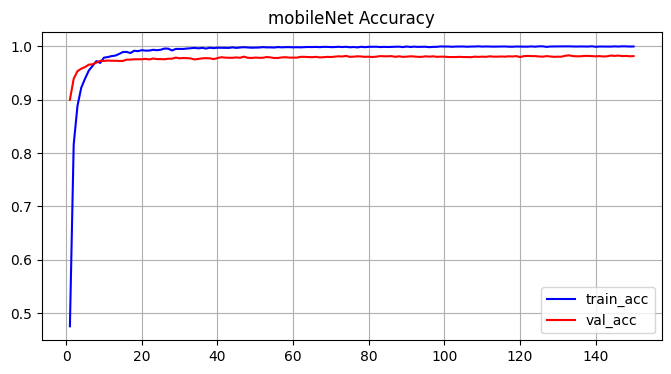

In [26]:
mobileNet_acc = mobileNet_history.history['accuracy']
mobileNet_val_acc = mobileNet_history.history['val_accuracy']

epochs = range(1, len(mobileNet_acc)+1)
plt.figure(figsize=(8, 4))
plt.title('mobileNet Accuracy')
plt.plot(epochs, mobileNet_acc, 'b', label='train_acc')
plt.plot(epochs, mobileNet_val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.show()

In [6]:
best_mobileNet= load_model(mobileNet_path)
mobileNet_test_res = best_mobileNet.evaluate(x_ts, y_test)
mobileNet_test_res

113/113 [==============================] - 46s 403ms/step - loss: 0.0834 - accuracy: 0.9800


[0.08338188380002975, 0.9800000190734863]

In [10]:
import time
start_time = time.time()
pred = best_mobileNet.predict(x_ts)
mobileNet_pred_time = time.time()-start_time
print("time : {}".format(mobileNet_pred_time))
print("pred shape:", pred.shape)

113/113 [==============================] - 34s 293ms/step
time : 34.10746741294861
pred shape: (3600, 30)


In [30]:
# test image 1장 예측 시간
temp = x_ts[1].reshape(1, 200, 150, 3)
start_time = time.time()
p = best_mobileNet.predict(temp)
print("time : {}".format(time.time()-start_time))

time : 0.07154297828674316


### # VGG

In [39]:
vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 75, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 75, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 75, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 37, 128)       0   

In [29]:
vgg16_history = vgg16.fit(x_trn, y_train, 
                    validation_split=0.2, shuffle=True,
                    epochs=150, batch_size=32, callbacks=[cb_checkpoint_vgg16])

Epoch 1/150
360/360 [==============================] - 76s 189ms/step - loss: 2.3691 - accuracy: 0.3321 - val_loss: 0.7395 - val_accuracy: 0.8313

Epoch 00001: val_accuracy improved from -inf to 0.83125, saving model to D:/dasol\vgg16_best_model.h5
Epoch 2/150
360/360 [==============================] - 56s 156ms/step - loss: 0.7595 - accuracy: 0.7823 - val_loss: 0.2806 - val_accuracy: 0.9278

Epoch 00002: val_accuracy improved from 0.83125 to 0.92778, saving model to D:/dasol\vgg16_best_model.h5
Epoch 3/150
360/360 [==============================] - 56s 156ms/step - loss: 0.4016 - accuracy: 0.8870 - val_loss: 0.1979 - val_accuracy: 0.9497

Epoch 00003: val_accuracy improved from 0.92778 to 0.94965, saving model to D:/dasol\vgg16_best_model.h5
Epoch 4/150
360/360 [==============================] - 56s 156ms/step - loss: 0.2771 - accuracy: 0.9232 - val_loss: 0.1384 - val_accuracy: 0.9628

Epoch 00004: val_accuracy improved from 0.94965 to 0.96285, saving model to D:/dasol\vgg16_best_mode

360/360 [==============================] - 56s 156ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0763 - val_accuracy: 0.9844

Epoch 00078: val_accuracy did not improve from 0.98507
Epoch 79/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0740 - val_accuracy: 0.9847

Epoch 00079: val_accuracy did not improve from 0.98507
Epoch 80/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0699 - val_accuracy: 0.9851

Epoch 00080: val_accuracy did not improve from 0.98507
Epoch 81/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.0696 - val_accuracy: 0.9854

Epoch 00081: val_accuracy improved from 0.98507 to 0.98542, saving model to D:/dasol\vgg16_best_model.h5
Epoch 82/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0740 - val_accuracy: 0.9854

Epo

360/360 [==============================] - 56s 156ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0774 - val_accuracy: 0.9858

Epoch 00118: val_accuracy did not improve from 0.98715
Epoch 119/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.0805 - val_accuracy: 0.9854

Epoch 00119: val_accuracy did not improve from 0.98715
Epoch 120/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0862 - val_accuracy: 0.9830

Epoch 00120: val_accuracy did not improve from 0.98715
Epoch 121/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0830 - val_accuracy: 0.9823

Epoch 00121: val_accuracy did not improve from 0.98715
Epoch 122/150
360/360 [==============================] - 56s 156ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0796 - val_accuracy: 0.9840

Epoch 00122: val_accuracy did not improve from 0.

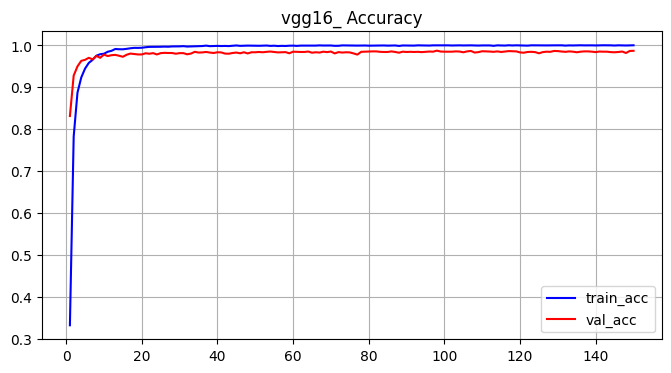

In [30]:
vgg16_acc = vgg16_history.history['accuracy']
vgg16_val_acc = vgg16_history.history['val_accuracy']

epochs = range(1, len(vgg16_acc)+1)
plt.figure(figsize=(8, 4))
plt.title('vgg16_ Accuracy')
plt.plot(epochs, vgg16_acc, 'b', label='train_acc')
plt.plot(epochs, vgg16_val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.show()

In [7]:
best_vgg16= load_model(vgg16_path)
vgg16_test_res = best_vgg16.evaluate(x_ts, y_test)
vgg16_test_res

113/113 [==============================] - 307s 3s/step - loss: 0.0837 - accuracy: 0.9828


[0.08370903879404068, 0.9827777743339539]

In [11]:
import time
start_time = time.time()
pred = best_vgg16.predict(x_ts)
vgg16_pred_time = time.time()-start_time
print("time : {}".format(vgg16_pred_time))
print("pred shape:", pred.shape)

113/113 [==============================] - 293s 3s/step
time : 293.96240043640137
pred shape: (3600, 30)


### # xception

In [40]:
xception.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [33]:
xception_history = xception.fit(x_trn, y_train, 
                    validation_split=0.2, shuffle=True,
                    epochs=150, batch_size=32, callbacks=[cb_checkpoint_xception])

Epoch 1/150
360/360 [==============================] - 217s 585ms/step - loss: 2.6228 - accuracy: 0.2855 - val_loss: 0.6259 - val_accuracy: 0.8531

Epoch 00001: val_accuracy improved from -inf to 0.85312, saving model to D:/dasol\xception_best_model.h5
Epoch 2/150
360/360 [==============================] - 195s 539ms/step - loss: 0.5811 - accuracy: 0.8462 - val_loss: 0.1369 - val_accuracy: 0.9667

Epoch 00002: val_accuracy improved from 0.85312 to 0.96667, saving model to D:/dasol\xception_best_model.h5
Epoch 3/150
360/360 [==============================] - 193s 537ms/step - loss: 0.2000 - accuracy: 0.9480 - val_loss: 0.0809 - val_accuracy: 0.9785

Epoch 00003: val_accuracy improved from 0.96667 to 0.97847, saving model to D:/dasol\xception_best_model.h5
Epoch 4/150
360/360 [==============================] - 194s 538ms/step - loss: 0.1138 - accuracy: 0.9718 - val_loss: 0.0626 - val_accuracy: 0.9837

Epoch 00004: val_accuracy improved from 0.97847 to 0.98368, saving model to D:/dasol\xc

360/360 [==============================] - 194s 538ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0485 - val_accuracy: 0.9903

Epoch 00039: val_accuracy did not improve from 0.99132
Epoch 40/150
360/360 [==============================] - 193s 537ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0495 - val_accuracy: 0.9892

Epoch 00040: val_accuracy did not improve from 0.99132
Epoch 41/150
360/360 [==============================] - 192s 534ms/step - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0479 - val_accuracy: 0.9896

Epoch 00041: val_accuracy did not improve from 0.99132
Epoch 42/150
360/360 [==============================] - 194s 538ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0466 - val_accuracy: 0.9913

Epoch 00042: val_accuracy did not improve from 0.99132
Epoch 43/150
360/360 [==============================] - 193s 536ms/step - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.0471 - val_accuracy: 0.9913

Epoch 00043: val_accuracy did not improve from 0


Epoch 00078: val_accuracy did not improve from 0.99201
Epoch 79/150
360/360 [==============================] - 193s 537ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0487 - val_accuracy: 0.9917

Epoch 00079: val_accuracy did not improve from 0.99201
Epoch 80/150
360/360 [==============================] - 193s 536ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0526 - val_accuracy: 0.9899

Epoch 00080: val_accuracy did not improve from 0.99201
Epoch 81/150
360/360 [==============================] - 193s 536ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0520 - val_accuracy: 0.9913

Epoch 00081: val_accuracy did not improve from 0.99201
Epoch 82/150
360/360 [==============================] - 193s 536ms/step - loss: 8.0623e-04 - accuracy: 1.0000 - val_loss: 0.0524 - val_accuracy: 0.9913

Epoch 00082: val_accuracy did not improve from 0.99201
Epoch 83/150
360/360 [==============================] - 192s 535ms/step - loss: 9.4013e-04 - accuracy: 0.9999 - val_loss: 0.

360/360 [==============================] - 193s 535ms/step - loss: 5.5038e-04 - accuracy: 1.0000 - val_loss: 0.0528 - val_accuracy: 0.9913

Epoch 00118: val_accuracy did not improve from 0.99271
Epoch 119/150
360/360 [==============================] - 192s 534ms/step - loss: 9.0444e-04 - accuracy: 0.9998 - val_loss: 0.0500 - val_accuracy: 0.9924

Epoch 00119: val_accuracy did not improve from 0.99271
Epoch 120/150
360/360 [==============================] - 192s 534ms/step - loss: 7.0805e-04 - accuracy: 0.9999 - val_loss: 0.0501 - val_accuracy: 0.9931

Epoch 00120: val_accuracy improved from 0.99271 to 0.99306, saving model to D:/dasol\xception_best_model.h5
Epoch 121/150
360/360 [==============================] - 193s 537ms/step - loss: 8.1239e-04 - accuracy: 0.9999 - val_loss: 0.0509 - val_accuracy: 0.9931

Epoch 00121: val_accuracy did not improve from 0.99306
Epoch 122/150
360/360 [==============================] - 192s 535ms/step - loss: 5.3860e-04 - accuracy: 1.0000 - val_loss: 0.

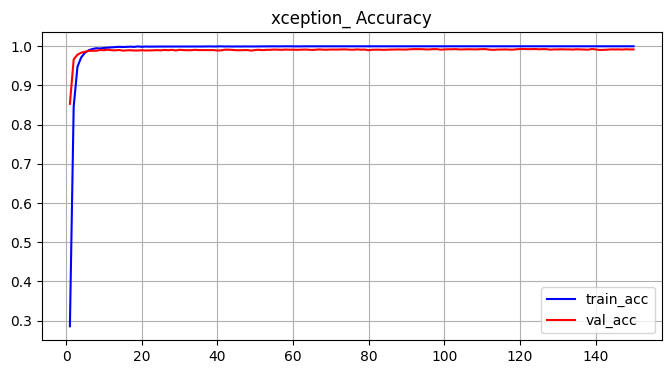

In [34]:
xception_acc = xception_history.history['accuracy']
xception_val_acc = xception_history.history['val_accuracy']

epochs = range(1, len(xception_acc)+1)
plt.figure(figsize=(8, 4))
plt.title('xception_ Accuracy')
plt.plot(epochs, xception_acc, 'b', label='train_acc')
plt.plot(epochs, xception_val_acc, 'r', label='val_acc')
plt.grid()
plt.legend()
plt.show()

In [8]:
best_xception = load_model(xception_path)
xception_test_res = best_xception.evaluate(x_ts, y_test)
xception_test_res

113/113 [==============================] - 181s 2s/step - loss: 0.0349 - accuracy: 0.9942


[0.034898173063993454, 0.9941666722297668]

In [12]:
import time
start_time = time.time()
pred = best_xception.predict(x_ts)
xception_pred_time = time.time()-start_time
print("time : {}".format(xception_pred_time))
print("pred shape:", pred.shape)

113/113 [==============================] - 139s 1s/step
time : 139.6585557460785
pred shape: (3600, 30)


### # 4개 모델 비교

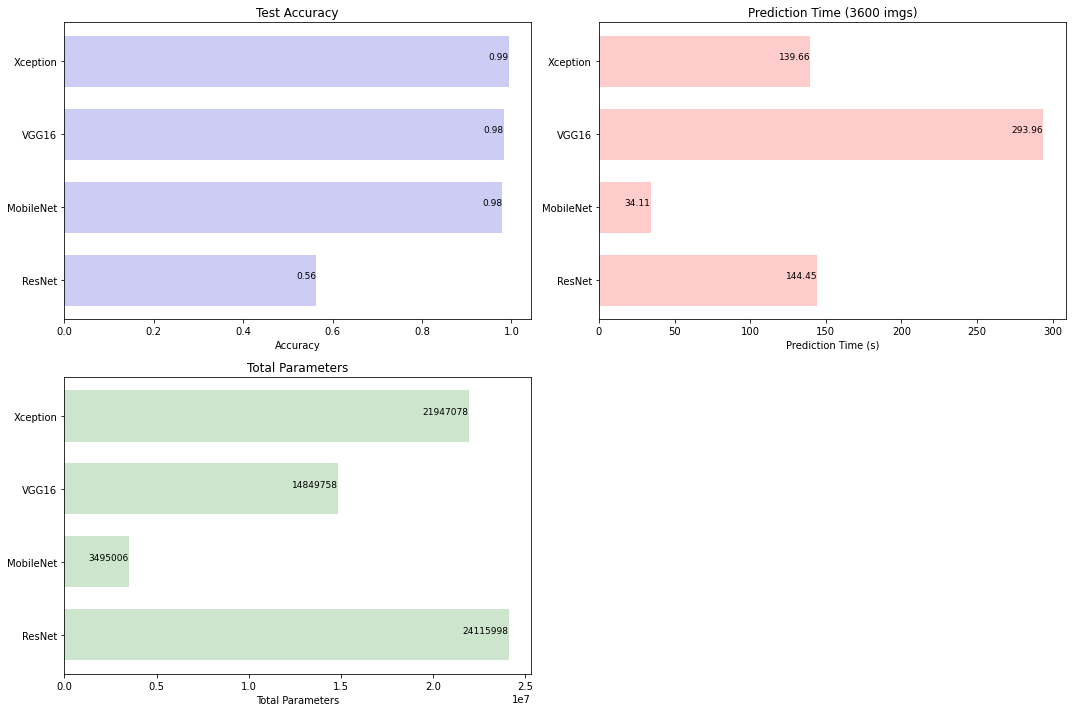

In [165]:
# 테스트 정확도 & 예측 시간 비교

test_results = [resNet_test_res[1], mobileNet_test_res[1], vgg16_test_res[1], xception_test_res[1]]
pred_times = [resNet_pred_time, mobileNet_pred_time, vgg16_pred_time, xception_pred_time]
total_params = [24115998, 3495006, 14849758, 21947078]
models = ["ResNet", "MobileNet", "VGG16", "Xception"]

data = [test_results, pred_times, total_params]
titles = ["Test Accuracy", "Prediction Time (3600 imgs)", "Total Parameters"]
xlabels = ["Accuracy", "Prediction Time (s)", "Total Parameters"]
color = ["mediumblue","red", "green"]
y_pos = np.arange(len(models))

plt.figure(figsize=(15, 10))
for i in range(3):
    ax = plt.subplot(2, 2, i+1)              
    ax.barh(y_pos, data[i], align='center', alpha=0.2, color=color[i], height=0.7)
    ax.set_yticks(y_pos, models)
    ax.set_xlabel(xlabels[i])
    ax.set_title(titles[i])
    for j, v in enumerate(y_pos):
        ax.text(data[i][v], v, str(round(data[i][j], 2))   ,
                 fontsize=9,
                 color="black",
                 horizontalalignment='right',
                 verticalalignment='bottom')
plt.tight_layout()
plt.show()

### # 결론
* 4개의 모델 비교 결과, 총 파라미터 수가 가장 적고 예측시간이 가장 빠르면서도 정확도가 높은 MobileNet이 현재 데이터셋에는 가장 적합해 보임<br><br>